In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
from keras.models import Model
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model



total cores: 256


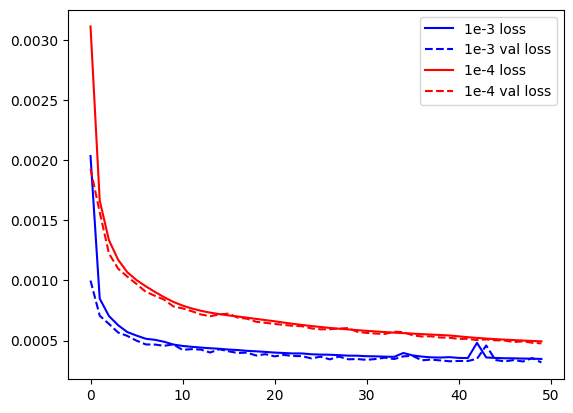

In [2]:
import pickle
with open('training_history_landmask_150k_1e3.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

with open('training_history_landmask_1e-4_150k.pkl', 'rb') as f:
    loaded_history_2 = pickle.load(f)


plt.plot(loaded_history["loss"][:50], "b", label="1e-3 loss")
plt.plot(loaded_history["val_loss"][:50], "b--", label="1e-3 val loss")

plt.plot(loaded_history_2["loss"][:50], "r", label="1e-4 loss")
plt.plot(loaded_history_2["val_loss"][:50], "r--", label="1e-4 val loss")
plt.legend()

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


#bands = [6, 7, 20, 28, 28, 31]
bands=[29]
#bands=[1]
folder = "/scratch/fslippe/modis/MOD02/daytime_1km/ /scratch/fslippe/modis/MOD02/boundary_1km/ /scratch/fslippe/modis/MOD02/night_1km/"


1 Physical GPUs, 1 Logical GPUs


2023-10-16 14:17:56.577096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15786 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [4]:
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
#folder = "/scratch/fslippe/modis/MOD02/daytime_1km/"# /scratch/fslippe/modis/MOD02/boundary_1km/"# /scratch/fslippe/modis/MOD02/night_1km/"

start = "20201201"
end = "20210430"
# start = "20210401"
# end = "20210430"


start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)
print(start_converted)
print(end_converted)
x, dates, masks = extract_1km_data(folder, bands=bands, start_date=start_converted, end_date=end_converted)
x, dates, masks = zip(*[(xi, date, mask) for xi, date, mask in zip(x, dates, masks) if (xi.shape[0] > 64) and (xi.shape[1] > 64)])
x = list(x)
dates = list(dates)

#x = extract_250m_data(folder, bands=[1], start_date=start_converted, end_date=end_converted)
len(masks)




total cores: 256
2020336
2021120
['/scratch/fslippe/modis/MOD02/daytime_1km/', '/scratch/fslippe/modis/MOD02/boundary_1km/', '/scratch/fslippe/modis/MOD02/night_1km/']


  0%|          | 0/151 [00:19<?, ?it/s]


In [3]:
import autoencoder
import importlib
importlib.reload(autoencoder)
from autoencoder import SobelFilterLayer, SimpleAutoencoder
patch_size = 64
#normalized_patches = np.concatenate([autoencoder.extract_patches(n_d) for n_d in normalized_data], axis=0)

In [26]:
from autoencoder import SobelFilterLayer, SimpleAutoencoder
patch_size = 64
print(len(bands))
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

#encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_band(6,20,29)_encoder")
encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_band(29)_filter_encoder")

1


In [27]:
max_vals = np.load("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_band(29)_max_vals.npy")
#max_vals = np.array([15.703261])
max_vals

array([[[[10.833669]]]], dtype=float32)

In [ ]:
#### EXTRACTING AND ENCODING PATCHES + SAVING indexes of belonging files
cluster_map = []
all_patches = []
starts = []
ends =[]
shapes = []
start = 0 

for (image, mask) in zip(x[:100], masks[:100]):
    shapes.append(image.shape[0:2])
    patches, idx, n_patches = autoencoder_predict.extract_patches(image, mask, mask_threshold=0.9)  # Assuming this function extracts and reshapes patches for a single image
    all_patches.append(patches)
    starts.append(start)
    ends.append(start + n_patches)
    start += len(patches)

# Stack filtered patches from all images
patches = np.concatenate(all_patches, axis=0) / max_vals


In [ ]:
val_data = np.load("/scratch/fslippe/modis/MOD02/test_data/normalized_testpatches_dnb_landmask_150k_band(29)_winter20_21.npy")


In [ ]:
encoded_patches = encoder.predict(val_data)
encoded_patches_flat = encoded_patches.reshape(encoded_patches.shape[0], -1)


In [6]:
### EXTRACT CAO AND NOn CAO CASES
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
# start = "20230303"
# end = "20230306"
start = "20210101"
end = "20210201"
#start = "20210701"
#end = "20210702"
start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)
#x_cao, dates_cao, masks_cao = extract_1km_data("/scratch/fslippe/modis/MOD02/july_2021/", bands=bands, start_date=start_converted, end_date=end_converted)

# x_cao, dates_cao, masks_cao, lon_lats = extract_1km_data("/scratch/fslippe/modis/MOD02/cao_test_data/",
#                                                          bands=bands,
#                                                          start_date=start_converted,
#                                                          end_date=end_converted,
#                                                          return_lon_lat=True)
x_cao, dates_cao, masks_cao, lon_lats = extract_1km_data(folder,
                                                         bands=bands,
                                                         start_date=start_converted,
                                                         end_date=end_converted,
                                                         return_lon_lat=True)
x_cao, dates_cao, masks_cao, lon_lats = zip(*[(xi, date, mask, lon_lat) for xi, date, mask, lon_lat in zip(x_cao, dates_cao, masks_cao, lon_lats) if (xi.shape[0] > 64) and (xi.shape[1] > 64)])

x_cao = list(x_cao)
dates_cao = list(dates_cao)


total cores: 256
['/scratch/fslippe/modis/MOD02/daytime_1km/', '/scratch/fslippe/modis/MOD02/boundary_1km/', '/scratch/fslippe/modis/MOD02/night_1km/']


100%|██████████| 32/32 [01:17<00:00,  2.44s/it]


In [7]:
#### EXTRACTING AND ENCODING PATCHES + SAVING indexes of belonging files
cluster_map_cao = []
all_patches_cao = []
all_lon_patches_cao = []
all_lat_patches_cao = []

starts_cao = []
ends_cao =[]
shapes_cao = []
start_cao = 0 
n_patches_tot = [] 
indices = []


#encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_band(6,20,29)_encoder")
#normalized_patches = np.concatenate([autoencoder.extract_patches(n_d) for n_d in normalized_data], axis=0)
i=0
tot = len(x_cao)
for (image, mask, lon_lat) in zip(x_cao, masks_cao, lon_lats):
    print("%s/%s" %(i, tot))
    shapes_cao.append(image.shape[0:2])
    patches_cao, idx_cao, n_patches, lon_cao, lat_cao = autoencoder_predict.extract_patches(image,
                                                                          mask,
                                                                          mask_threshold=0.9,
                                                                          lon_lat=lon_lat,
                                                                          extract_lon_lat=True)  # Assuming this function extracts and reshapes patches for a single image
    #patches_cao = autoencoder_predict.extract_patches(image)  # Assuming this function extracts and reshapes patches for a single image
    n_patches_cao = len(patches_cao)
    all_patches_cao.append(patches_cao)
    all_lon_patches_cao.append(lon_cao)
    all_lat_patches_cao.append(lat_cao)


    starts_cao.append(start_cao)
    ends_cao.append(start_cao + n_patches_cao)
    n_patches_tot.append(n_patches)
    indices.append(idx_cao)
    start_cao += n_patches_cao
    i+=1
# Stack filtered patches from all images
patches_cao = np.concatenate(all_patches_cao, axis=0) / max_vals

encoded_patches_cao = encoder.predict(patches_cao)
encoded_patches_flat_cao = encoded_patches_cao.reshape(encoded_patches_cao.shape[0], -1)


gc.collect()
# cluster_map_no = []
# all_patches_no = []
# starts_no = []
# ends_no =[]
# shapes_no = []
# start_no = 0 

# for image in x_no:
#     shapes_no.append(image.shape[0:2])
#     patches_no = autoencoder_predict.extract_patches(image)  # Assuming this function extracts and reshapes patches for a single image
#     all_patches_no.append(patches_no)
#     starts_no.append(start_no)
#     ends_no.append(start_no + len(patches_no))
#     start_no += len(patches_no)
#     # Calculate the dimensions of the reduced resolution array
# # Stack filtered patches from all images
# patches_no = np.concatenate(all_patches_no, axis=0) / max_vals
# encoded_patches_no = encoder.predict(patches_no)
# encoded_patches_flat_no = encoded_patches_no.reshape(encoded_patches_no.shape[0], -1)



0/771
1/771
2/771
3/771
4/771
5/771
6/771
7/771
8/771
9/771
10/771
11/771
12/771
13/771
14/771
15/771
16/771
17/771
18/771
19/771
20/771
21/771
22/771
23/771
24/771
25/771
26/771
27/771
28/771
29/771
30/771
31/771
32/771
33/771
34/771
35/771
36/771
37/771
38/771
39/771
40/771
41/771
42/771
43/771
44/771
45/771
46/771
47/771
48/771
49/771
50/771
51/771
52/771
53/771
54/771
55/771
56/771
57/771
58/771
59/771
60/771
61/771
62/771
63/771
64/771
65/771
66/771
67/771
68/771
69/771
70/771
71/771
72/771
73/771
74/771
75/771
76/771
77/771
78/771
79/771
80/771
81/771
82/771
83/771
84/771
85/771
86/771
87/771
88/771
89/771
90/771
91/771
92/771
93/771
94/771
95/771
96/771
97/771
98/771
99/771
100/771
101/771
102/771
103/771
104/771
105/771
106/771
107/771
108/771
109/771
110/771
111/771
112/771
113/771
114/771
115/771
116/771
117/771
118/771
119/771
120/771
121/771
122/771
123/771
124/771
125/771
126/771
127/771
128/771
129/771
130/771
131/771
132/771
133/771
134/771
135/771
136/771
137/771
138/77

2023-10-16 14:21:11.907635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


2048

In [28]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib

#cluster = MiniBatchKMeans(11, batch_size=32, random_state=42).fit(encoded_patches_flat)
#joblib.dump(clust
# er, '/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_band(29).pkl')
cluster = joblib.load('/uio/hume/student-u37/fslippe/data/models/cluster_winter_2020_21_dnb_landmask_band(29)_lab1.pkl')

#decoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_band(29)_filter_encoder")


In [9]:
tmp = indices
gc.collect()

0

12
(3,)
(41,)
(20,)
(250,)
(5,)
(51,)
(0,)
(94,)
(428,)
(174,)


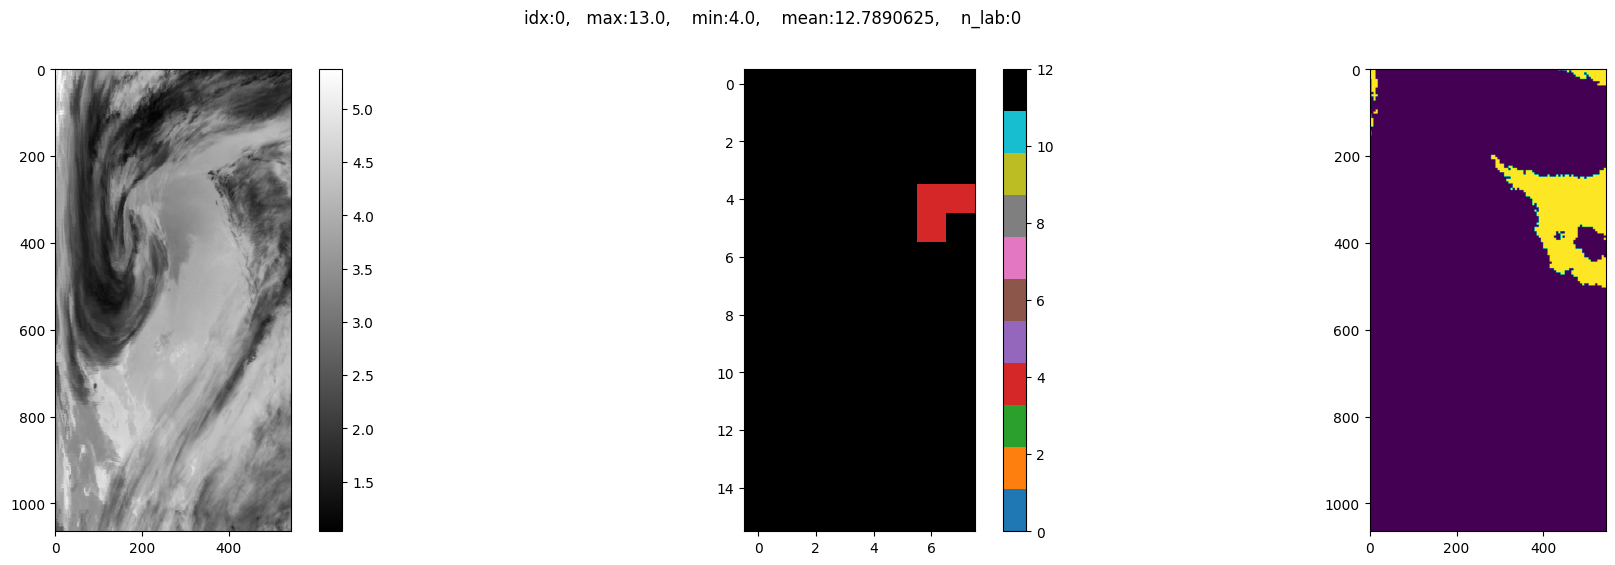

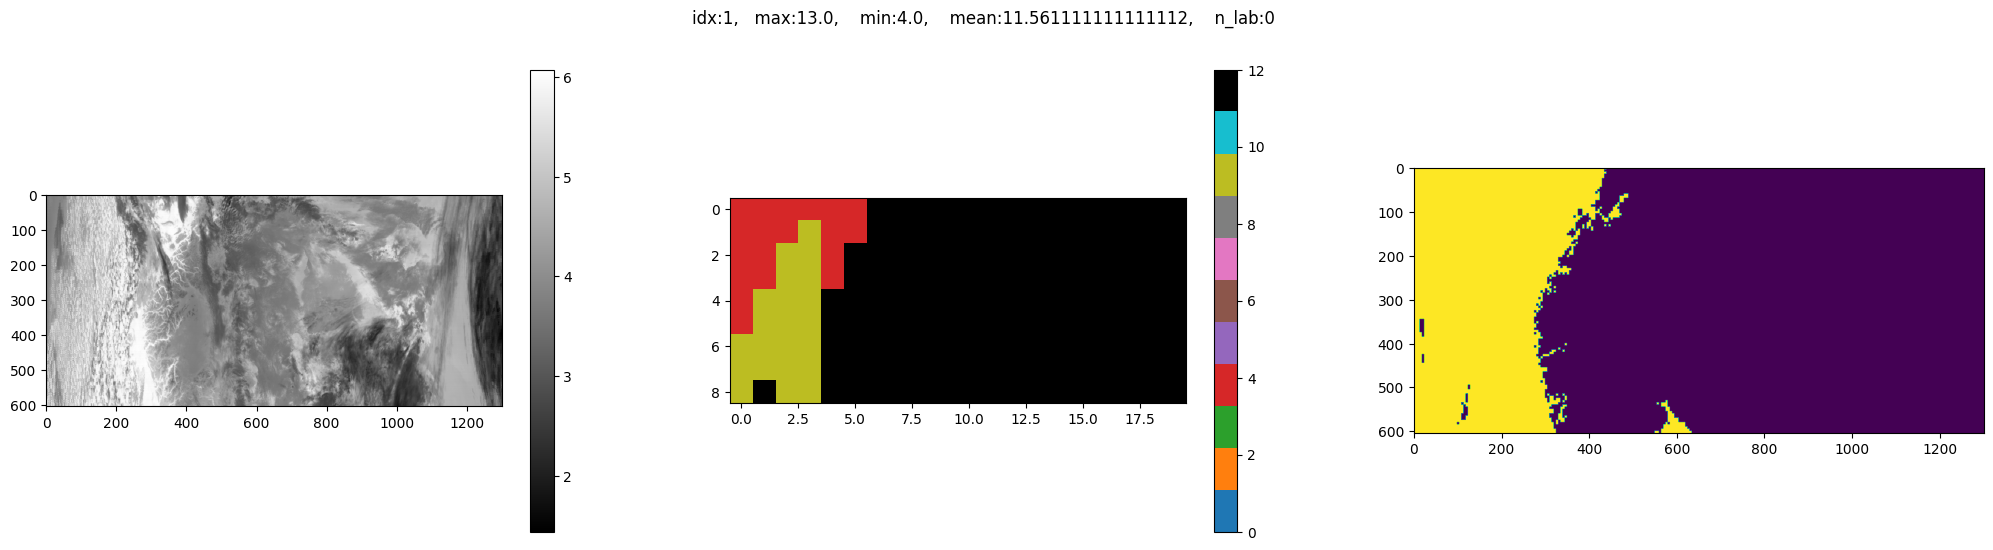

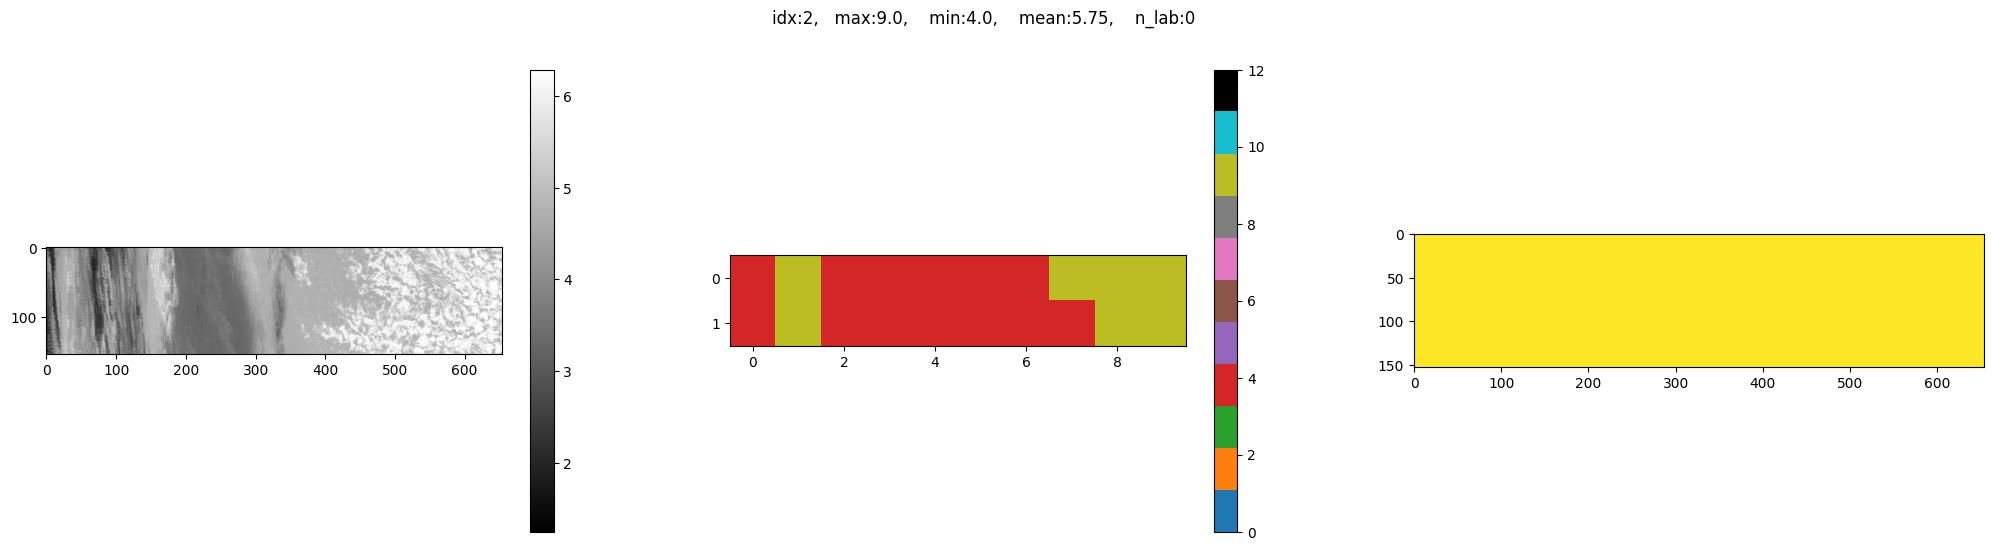

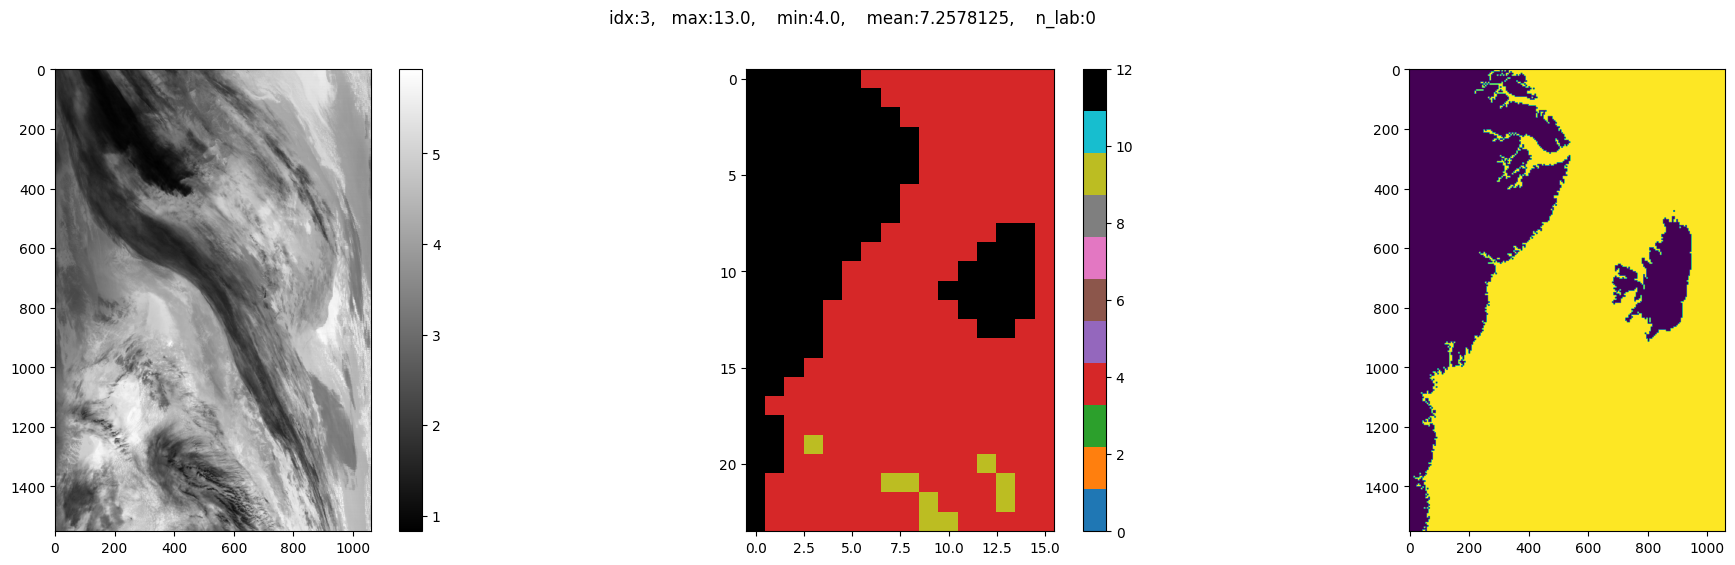

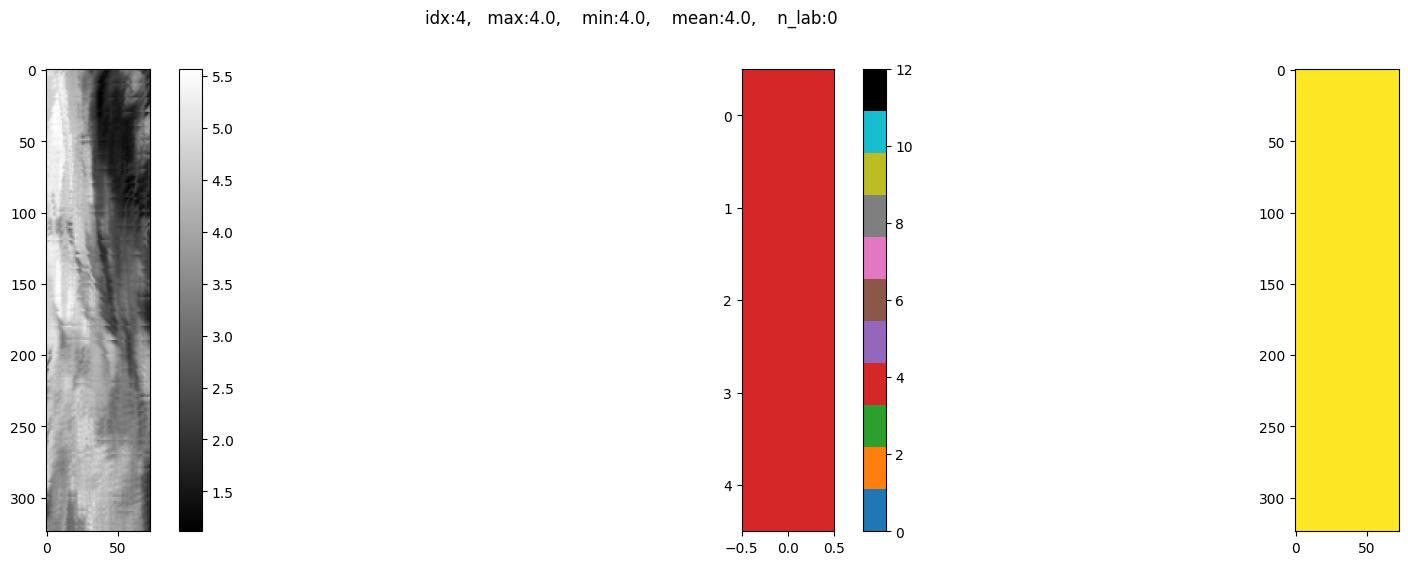

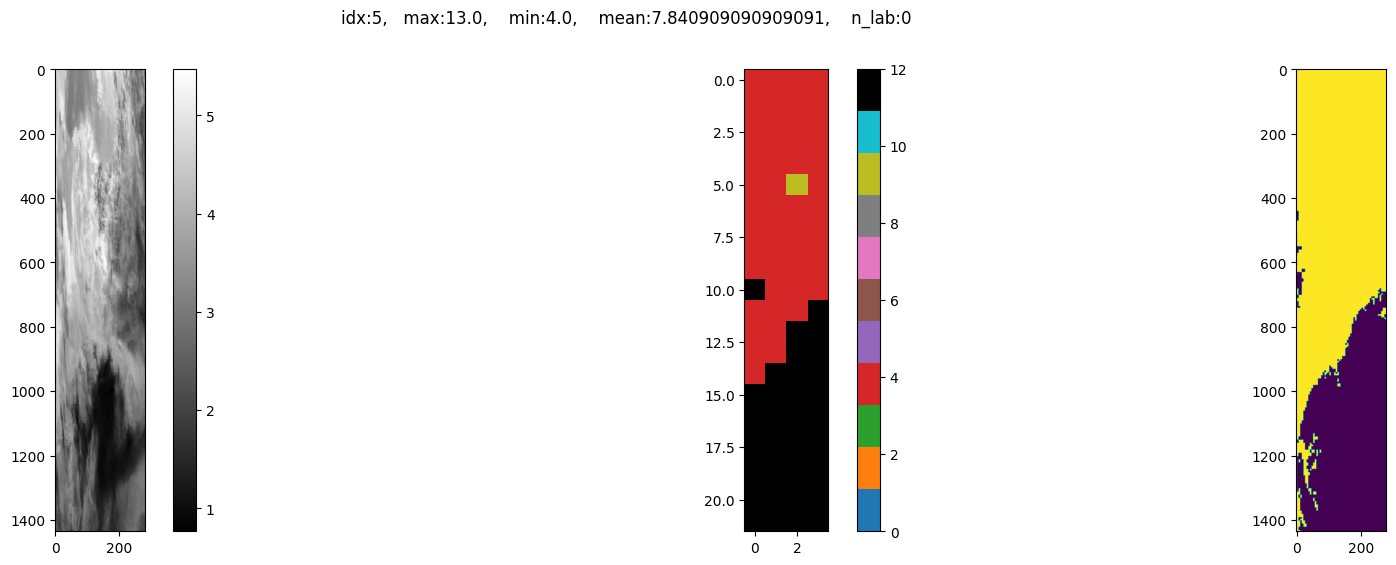

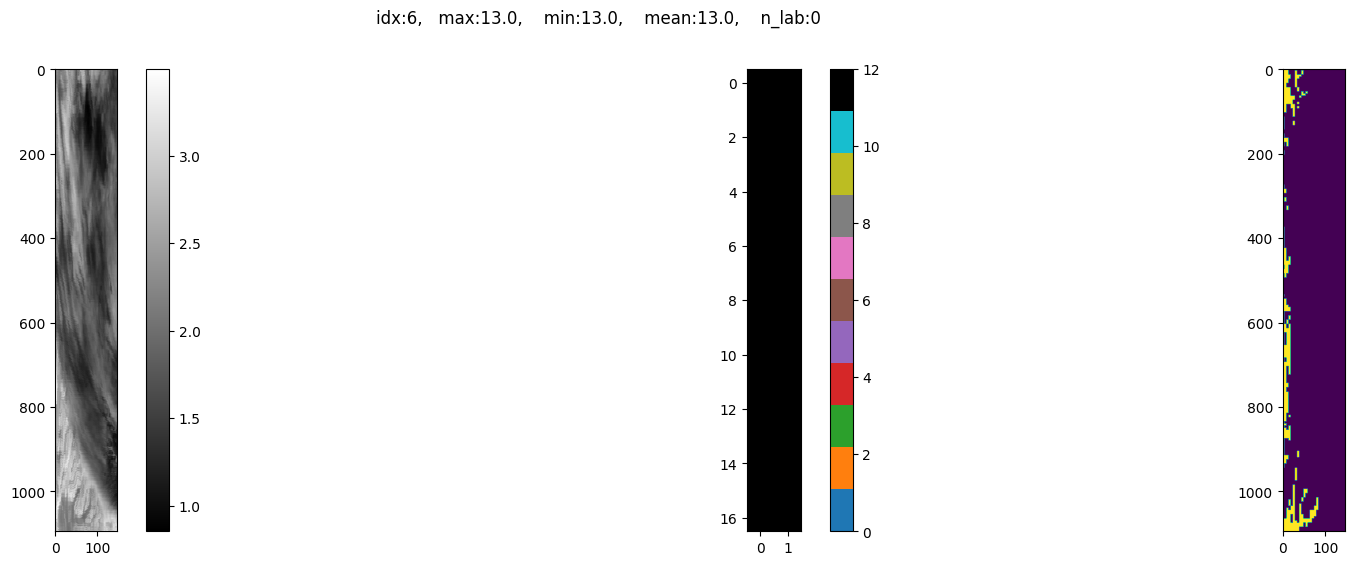

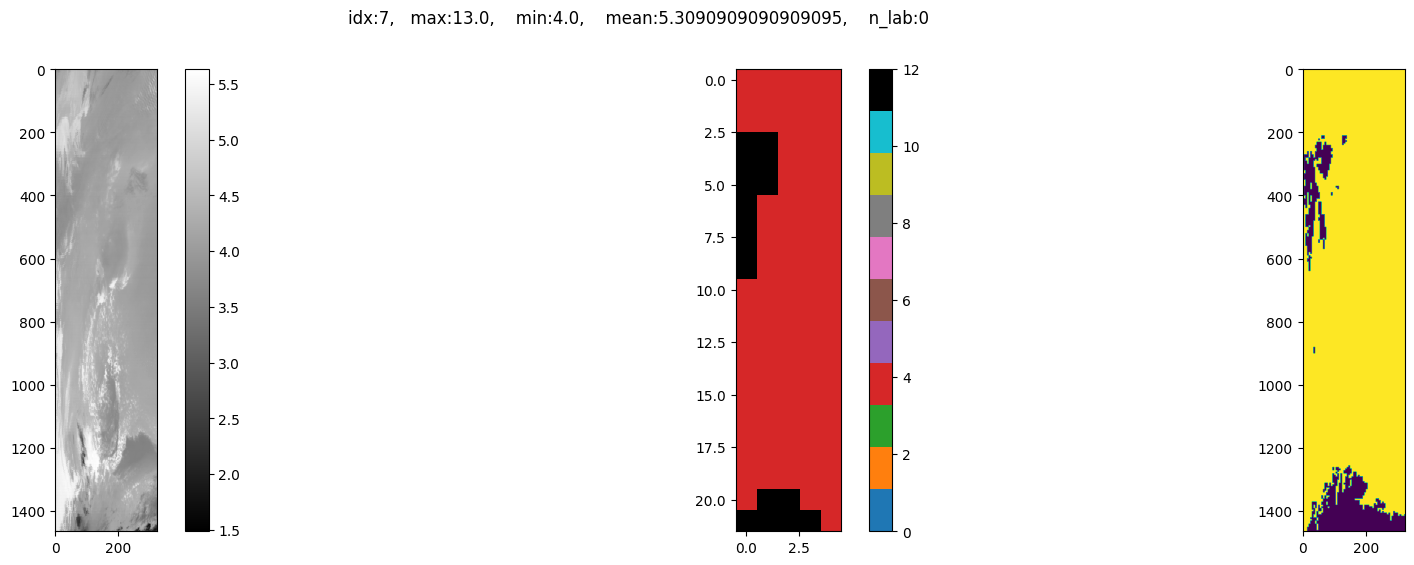

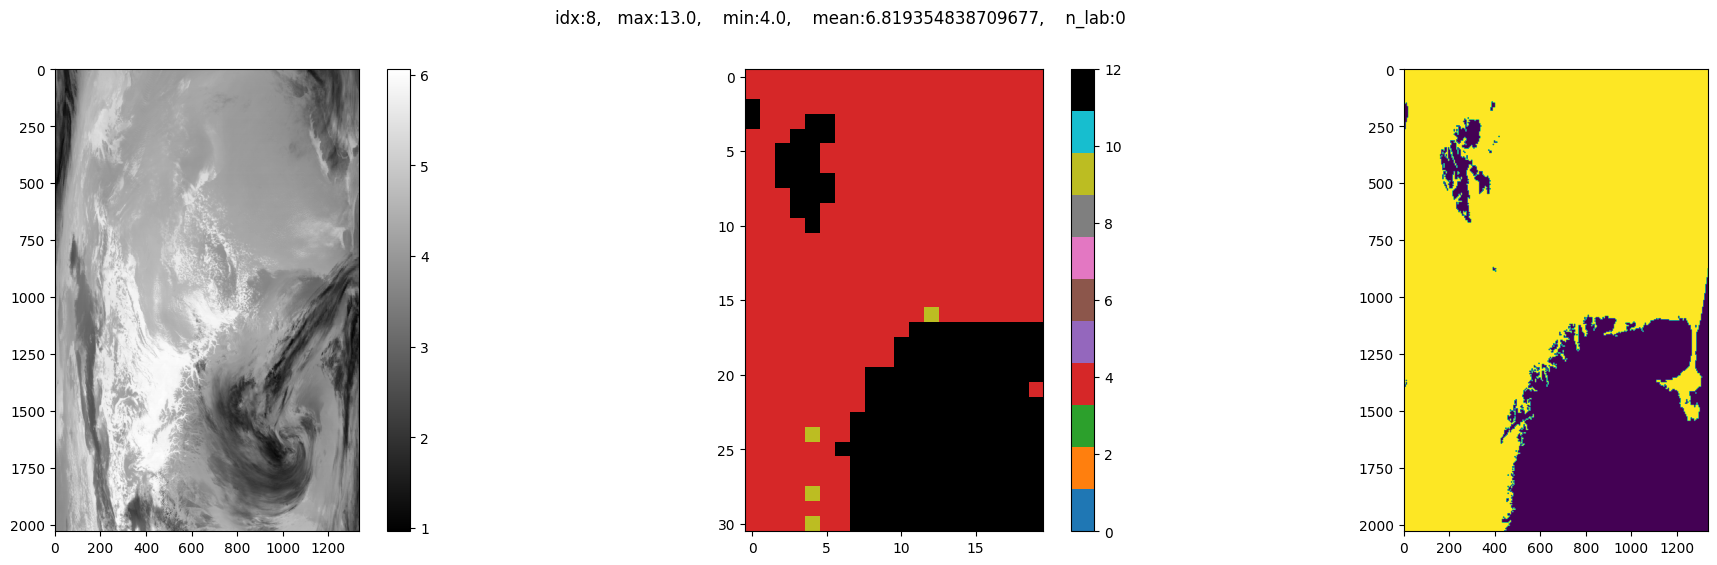

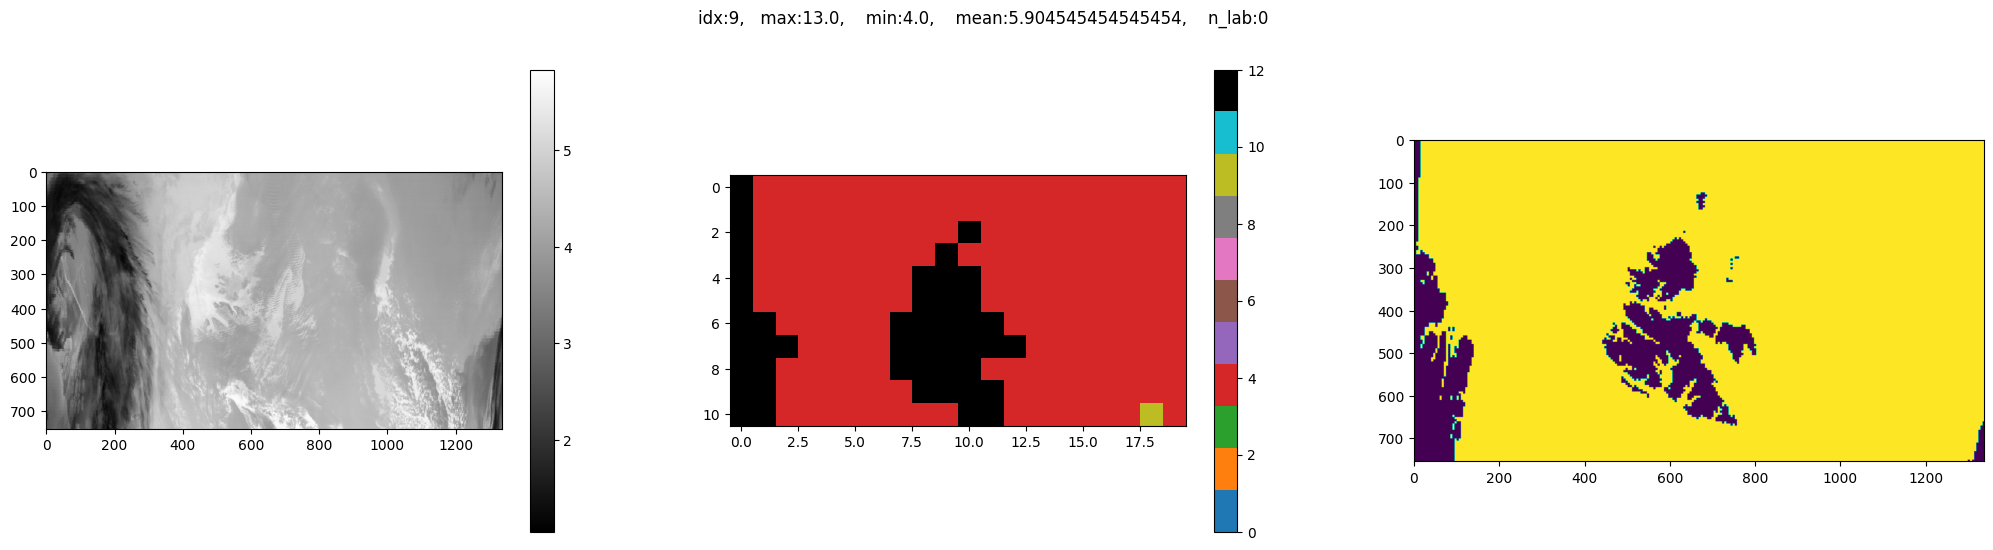

In [30]:
import matplotlib.colors as mcolors
index_list = [0,1,2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19]
#index_list = range(len(x_cao))
#index_list = [2]

#cluster_predict = cluster.predict(encoded_patches_flat_cao)
labels = cluster_predict#.labels_
cluster_map_cao = []

global_min = np.min([np.min(cm) for cm in cluster.labels_])
global_max = np.max([np.max(cm) for cm in cluster.labels_])+2
norm = Normalize(vmin=global_min, vmax=global_max)  
print(global_max)

norm_mask = Normalize(vmin=0, vmax=1)  

cmap_tab10 = plt.cm.tab10
colors_tab10 = cmap_tab10(np.arange(cmap_tab10.N))

# Add black to the end
black = np.array([0, 0, 0, 1])
colors_new = np.vstack((colors_tab10, black))

# Create a new colormap from the combined list of colors
new_cmap = mcolors.ListedColormap(colors_new)

# boundaries = np.arange(global_max+1) 
# norm = mcolors.BoundaryNorm(boundaries, new_cmap.N, clip=True)
# Assuming your original data shape is (height, width)
start = 0
tot_pics = 10
for i in range(start, start + tot_pics):
    height, width = shapes_cao[i]

    # Calculate the dimensions of the reduced resolution array
    reduced_height = height // patch_size
    reduced_width = width //patch_size
    current_labels = np.ones((n_patches_tot[i]))*(global_max+1)
    print(labels[starts_cao[i]:ends_cao[i]].shape)

    current_labels[np.squeeze(indices[i].numpy())] = labels[starts_cao[i]:ends_cao[i]]
   
    cluster_map_cao.append(np.reshape(current_labels, (reduced_height, reduced_width)))
    fig, axs = plt.subplots(1,3, figsize=(25, 6))
    fig.suptitle("idx:%s,   max:%s,    min:%s,    mean:%s,    n_lab:%s" %(i, np.max(current_labels), np.min(current_labels), np.mean(current_labels), np.sum((cluster_map_cao[i-start].ravel()==2))))
    cb = axs[0].imshow(x_cao[i], cmap="gray")
    plt.colorbar(cb)
    #axs[0].contourf(lon_lats[i][0][0,:], lon_lats[i][1][:,0], x_cao[i][:,:,0], cmap="gray")

    #axs[0].pcolormesh(lon_lats[i][0], lon_lats[i][1], x_cao[i][:,:,0], cmap="gray")
    cb = axs[1].imshow(cluster_map_cao[i-start], cmap=new_cmap, norm=norm)
    plt.colorbar(cb)
    axs[2].imshow(masks_cao[i], norm=norm_mask)



In [22]:
desired_label = 2
size_threshold = 1
all_region_lon = []
all_region_lat = []

print(all_lon_patches_cao[1].shape)
print(all_lat_patches_cao[1].shape)

for i in range(len(x_cao)):
    height, width = shapes_cao[i]

    # Calculate the dimensions of the reduced resolution array
    reduced_height = height // patch_size
    reduced_width = width //patch_size
    current_labels = np.ones((n_patches_tot[i]))*(global_max+1)
    current_labels[np.squeeze(indices[i].numpy())] = labels[starts_cao[i]:ends_cao[i]]

    current_lon = np.empty((n_patches_tot[i], 64, 64))
    current_lon[np.squeeze(indices[i].numpy())] = all_lon_patches_cao[i]
    lon_map = np.reshape(current_lon, (reduced_height, reduced_width, 64, 64))

    current_lat = np.empty((n_patches_tot[i], 64, 64))
    current_lat[np.squeeze(indices[i].numpy())] = all_lat_patches_cao[i]
    lat_map = np.reshape(current_lat, (reduced_height, reduced_width, 64, 64))

    label_map = np.reshape(current_labels, (reduced_height, reduced_width))
    # fig, axs = plt.subplots(1, 3, dpi=250)
    # cb = axs[0].imshow(label_map, cmap="tab10", norm=norm)
    # plt.colorbar(cb)
    # axs[1].imshow(x_cao[i], cmap="gray")
    binary_map = (label_map == desired_label)
    # axs[2].imshow(binary_map, cmap="gray")

    # Label connected components
    labeled_map, num_features = ndimage.label(binary_map)
    # plt.figure()
    # plt.title("%.1f       %.1f       %.1f       %.1f"%(lon_map.max(), lon_map.min(), lat_map.max(), lat_map.min()))
    # plt.imshow(x_cao[i])
    # Measure sizes of connected components
    region_sizes = ndimage.sum(binary_map, labeled_map, range(num_features + 1))

    # Iterate through each region and check if its size exceeds the threshold
    for region_idx, region_size in enumerate(region_sizes):
        if region_size > size_threshold:
            # fig, axs = plt.subplots(1, 3, figsize=[20, 7])

            # axs[0].pcolormesh( lon_lats[i][0], lon_lats[i][1], x_cao[i][:,:,0], cmap="gray")
            # axs[1].imshow(label_map, cmap="tab10", norm=norm)
            # axs[2].imshow(x_cao[i], cmap="gray")
            # Get the indices of the region
            region_coordinates = np.where(labeled_map == region_idx)
            all_region_lon.append(lon_map[region_coordinates])
            all_region_lat.append(lat_map[region_coordinates])
        

all_region_lon_flat = np.concatenate(all_region_lon)
all_region_lat_flat = np.concatenate(all_region_lat)


(41, 64, 64)
(41, 64, 64)


NameError: name 'all_region_lon_flat' is not defined

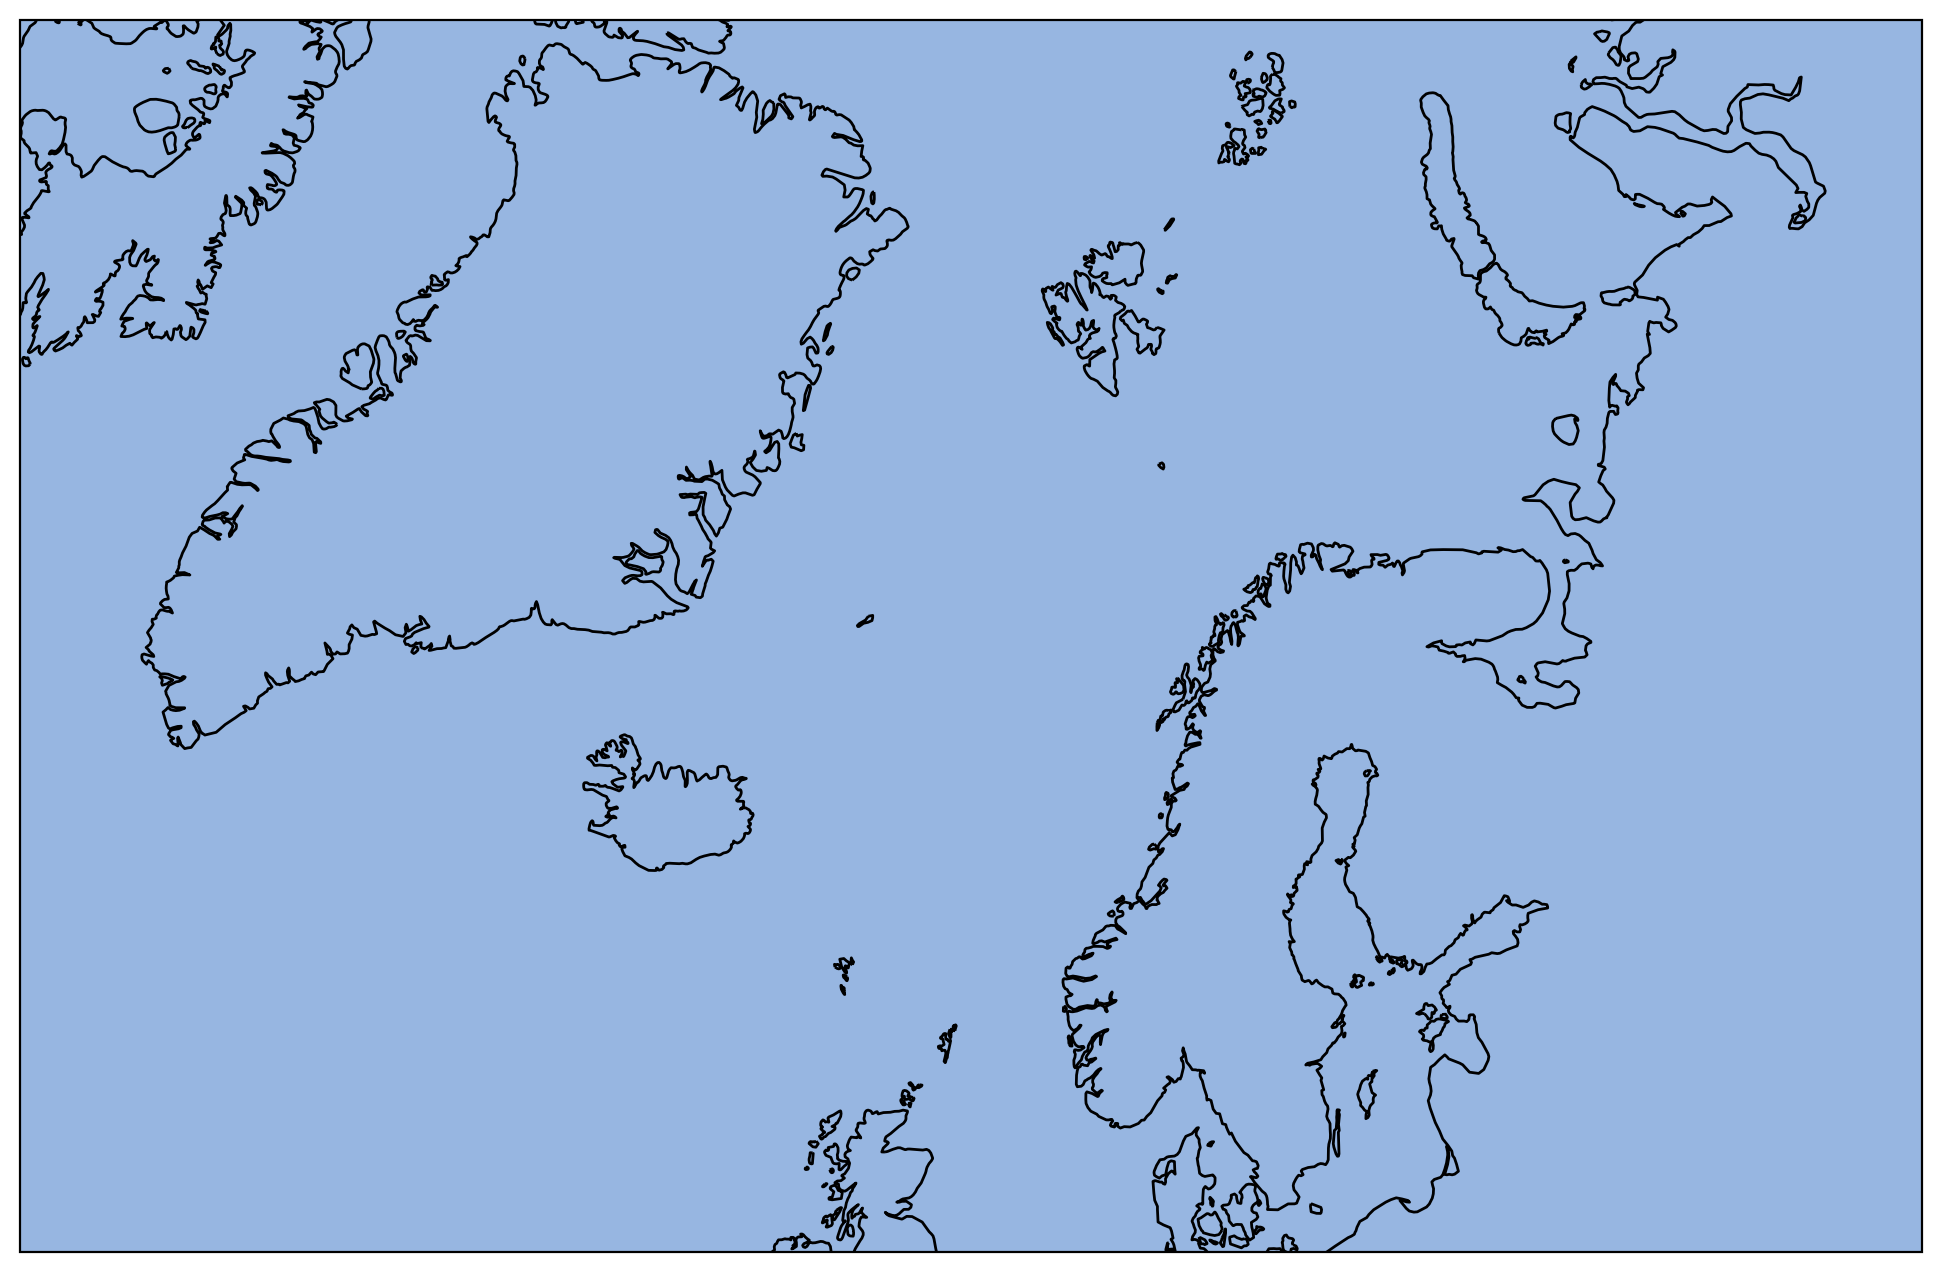

In [12]:
import cartopy.feature as cfeature

# Set up the polar stereographic map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Stereographic(central_latitude=90)},
                       figsize=(14, 8), dpi=200)
ax.set_extent([-45, 45, 55, 86], ccrs.PlateCarree())  # Set extent to focus on the Arctic

# Add features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

# Calculate the 2D histogram using numpy
#counts_all, xedges, yedges = np.histogram2d(all_region_lon_flat.ravel(), all_region_lat_flat.ravel(), bins=50)

# Normalize counts_all to percentage
#total_count = counts_all.sum()
#percentage_counts_all = (counts_all / total_count) * 100

# Display the histogram as a percentage
#c = ax.pcolormesh(xedges, yedges, percentage_counts_all.T, transform=ccrs.PlateCarree())
# Compute bin centers
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2

# Use contourf to plot
#c = ax.contourf(xcenters, ycenters, percentage_counts_all.T, transform=ccrs.PlateCarree(), levels=10, cmap="turbo")

fig.suptitle("Percentage of CAO open cells in different areas")
# Colorbar displaying percentages
#cbar = fig.colorbar(c, ax=ax, label='Percentage (%)', pad=0.05)
plt.scatter(xcenters, ycenters)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

In [233]:
march_idx = np.where(np.array(dates_cao) == str(convert_to_day_of_year("20210301")))[0][0]


1423

In [19]:
import numpy as np
import cartopy.crs as ccrs
from scipy.spatial import cKDTree

# Define the grid in projected coordinates
grid_resolution = 100e3  # 100km
projection = ccrs.Stereographic(central_latitude=90)
x_extent = [-4e6, 4e6]
y_extent = [-4e6, 4e6]

x_grid, y_grid = np.meshgrid(np.arange(x_extent[0], x_extent[1], grid_resolution),
                             np.arange(y_extent[0], y_extent[1], grid_resolution))

# Initialize the count matrix
counts = np.zeros_like(x_grid)

# Create a KDTree for faster nearest neighbor search
tree = cKDTree(list(zip(x_grid.ravel(), y_grid.ravel())))

# This will track which dates have been counted for each grid cell
dates_counted = {}

desired_label = 2
size_threshold = 10
all_region_lon = []
all_region_lat = []
s = 0
for i in range(len(x_cao)):
    height, width = shapes_cao[i]

    # Calculate the dimensions of the reduced resolution array
    reduced_height = height // patch_size
    reduced_width = width //patch_size
    
    current_labels = np.ones((n_patches_tot[i]))*(global_max+1)
    current_labels[np.squeeze(indices[i].numpy())] = labels[starts_cao[i]:ends_cao[i]]

    current_lon = np.empty((n_patches_tot[i], 64, 64))
    current_lon[np.squeeze(indices[i].numpy())] = all_lon_patches_cao[i]
    lon_map = np.reshape(current_lon, (reduced_height, reduced_width, 64, 64))

    current_lat = np.empty((n_patches_tot[i], 64, 64))
    current_lat[np.squeeze(indices[i].numpy())] = all_lat_patches_cao[i]
    lat_map = np.reshape(current_lat, (reduced_height, reduced_width, 64, 64))

    label_map = np.reshape(current_labels, (reduced_height, reduced_width))
    
    binary_map = (label_map == desired_label)

    # Label connected components
    labeled_map, num_features = ndimage.label(binary_map)

    # Measure sizes of connected components
    region_sizes = ndimage.sum(binary_map, labeled_map, range(num_features + 1))

    # Get the date associated with the current x_cao[i]
    current_date = dates_cao[i]

    # Iterate through each region and check if its size exceeds the threshold
    for region_idx, region_size in enumerate(region_sizes):
        if region_size > size_threshold:
            # Get the indices of the region
            region_coordinates = np.where(labeled_map == region_idx)
            
            # Convert to projected coordinates
            x_proj, y_proj = projection.transform_points(ccrs.PlateCarree(), 
                                                        lon_map[region_coordinates].ravel(), 
                                                        lat_map[region_coordinates].ravel())[:, :2].T
            s+=1

            # Query the KDTree for nearest grid points
            _, idxs = tree.query(list(zip(x_proj, y_proj)))  

            # Check and Increment the counts based on date condition
            for idx in idxs:
                if idx not in dates_counted:
                    dates_counted[idx] = set()
                if current_date not in dates_counted[idx]:
                    counts.ravel()[idx] += 1
                    dates_counted[idx].add(current_date)

# Visualize the result



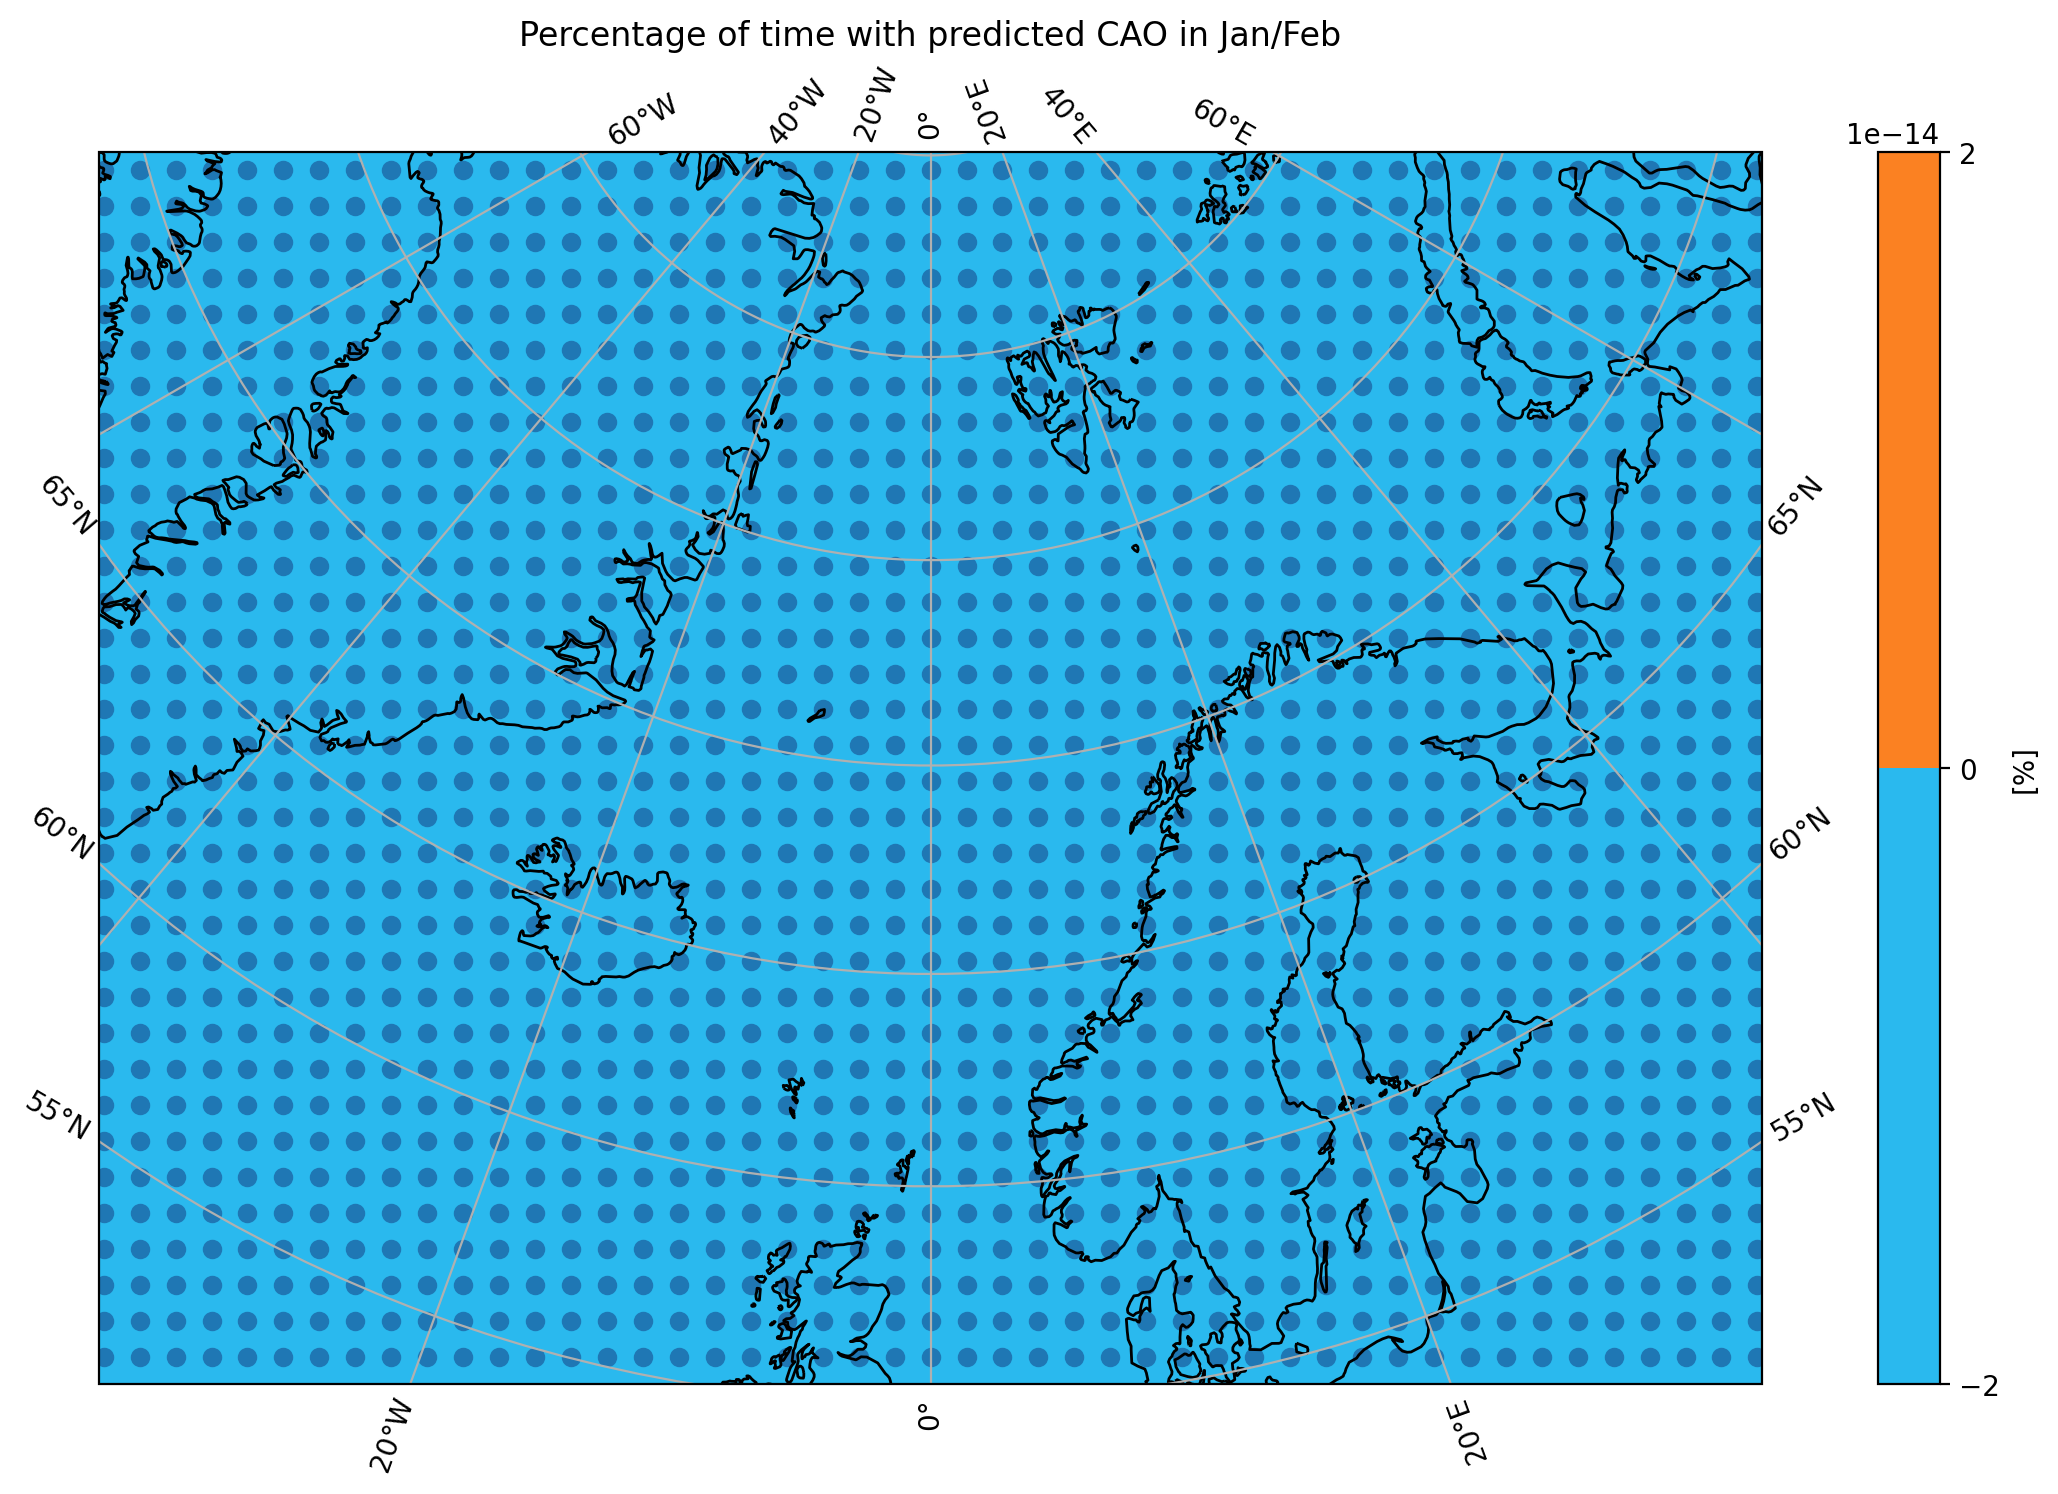

In [20]:
# Visualize the result
tot_days = int(dates_cao[-1]) - int(dates_cao[0])

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(15, 8), dpi=200)
plt.title("Percentage of time with predicted CAO in Jan/Feb")
ax.set_extent([-35, 35, 55, 84], ccrs.PlateCarree())  # Set extent to focus on the Arctic

ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

c = ax.contourf(x_grid, y_grid, counts/tot_days*100, transform=projection, levels=10, cmap="turbo")
plt.colorbar(c, ax=ax, orientation='vertical', label='[%]')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.scatter(x_grid, y_grid)
plt.show()
